In [154]:
import pymc
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns


from pymc import HalfCauchy, Model, Normal, sample

In [157]:
df = pd.read_csv("football.csv", delimiter=";")

In [97]:
test = df.loc[df["GoalsScored"].isna()]
train = df.loc[df["GoalsScored"].notna()]

X_train = train.drop(columns="GoalsScored").to_numpy()
y_train = train["GoalsScored"].to_numpy()

X_test = test.drop(columns="GoalsScored").to_numpy()
y_test = test["GoalsScored"].to_numpy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = np.column_stack((X_train, np.ones(X_train.shape[0])))

In [104]:
names = [col[2:] for col in df.columns if col != "GoalsScored"]
names.append("Intercept")

with pm.Model(coords={"b": names}) as poisson_model:

    # b_0 = Normal("b_0", 0, sigma=5)
    b = Normal("b_", 0, sigma=10, shape=X_train.shape[1], dims=["b"])
    lambda_ = pm.math.exp(pm.math.dot(X_train, b))

    y_obs = pm.Poisson("y_obs", mu=lambda_, observed=y_train)

    idata = sample(3000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_]


c:\Users\matej\miniconda3\envs\MLDS_HW1\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 71 seconds.


Text(0.5, 0, 'Coefficient (β)')

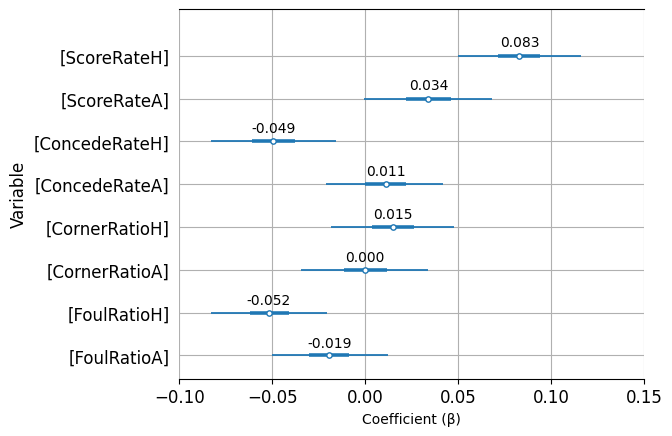

In [ ]:
import arviz.labels as azl

excluded_names = [n for n in names if n != "Intercept"]
labeller = azl.MapLabeller(var_name_map={"b_": ""})

summary = az.summary(idata, hdi_prob=0.95)

# Drop intercept row by name or index (assuming it's last)
summary_trimmed = summary.iloc[:-1]

ax = az.plot_forest(
    idata,
    var_names=["b_"],
    combined=True,
    coords={"b": excluded_names},
    hdi_prob=0.95,
    labeller=labeller,
    textsize=12,
)
means = summary_trimmed["mean"].values
y_pos = np.arange(len(means))

for i, mean in enumerate(reversed(means)):
    ax[0].text(mean, 0.1 + i + (-i*0.17), f"{mean:.3f}", ha='center', va='bottom', fontsize=10, color='black')


ax[0].grid(True, axis='both')
ax[0].set_ylabel("Variable", size=12)
ax[0].set_title(None)
ax[0].set_xlim(-0.1, 0.15)

# Set ticks at intervals of 0.05 within that range
ticks = np.arange(-0.1, 0.16, 0.05)
ax[0].set_xticks(ticks)
ax[0].set_xlabel("Coefficient (β)", size=12)

# Laplace Approximation

In [135]:
from scipy.optimize import minimize

X_test
betas_0 = np.zeros(X_train.shape[1])
alpha = 10

def neg_log_posterior(betas, X, y, alpha):
    eta = X @ betas
    return np.sum(np.exp(eta) - y * eta) + (1 / (2 * alpha)) * np.sum(betas**2)

# def grad(betas, X, y, alpha):
#     return - X @ y + X @ np.exp(X @ betas) + 1/alpha * betas

def grad(betas, X, y, alpha):
    return X.T @ (np.exp(X @ betas) - y) + (1 / alpha) * betas

# def hessian(betas, X, y, alpha):
#     return - X @ np.diag(np.exp(X @ betas)) @ X + 1/alpha * np.eye(X.shape[0], X.shape[0])

def hessian(betas, X, y, alpha):
    mu = np.exp(X @ betas)
    D = np.diag(mu)
    return X.T @ D @ X + (1 / alpha) * np.eye(X.shape[1])

res = minimize(
    neg_log_posterior,
    betas_0,
    args=(X_train, y_train, alpha),
    method='Newton-CG',  # or 'Newton-CG', 'BFGS', etc.
    jac=grad,
    hess=hessian
)

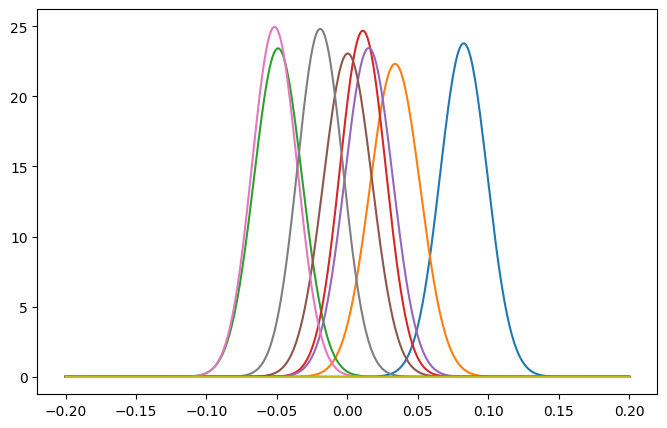

In [136]:
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal, mode
import numpy as np
betas = res.x

hess = hessian(betas, X_train, y_train, alpha)
cov = np.linalg.inv(hess)

x_vals = np.linspace(-0.2, 0.2, 500)  # Adjust range if needed
plt.figure(figsize=(8, 5))

for i, b in enumerate(betas):
    mean = b
    variance = cov[i][i]
    std = np.sqrt(variance)
    y_vals = norm.pdf(x_vals, loc=mean, scale=std)
    plt.plot(x_vals, y_vals, label=f'β{i}')


# Making point predictions

Loss functions

In [137]:
def squared_error(y_pred, y_true):
    return(np.mean((y_pred - y_true)**2))

def absolute_error(y_pred, y_true):
    return(np.mean(np.abs(y_pred - y_true)))

def accuracy(y_pred, y_true):
    correct_counts = 0

    for s in range(y_pred.shape[0]):  # iterate over samples
        sample_pred = np.round(y_pred[s, :])       # shape (N,)
        correct = np.sum(sample_pred == np.round(y_true))
        correct_counts += correct

    accuracy = correct_counts / (y_pred.shape[0] * y_pred.shape[1])
    return accuracy

In [138]:
rv = multivariate_normal(betas, cov)

np.random.seed(42)

beta_matrix = rv.rvs(1000)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = np.column_stack((X_test_scaled, np.ones(X_test_scaled.shape[0])))

predictions = np.exp(beta_matrix @ X_test_scaled.T)

y_samples = np.random.poisson(lam=predictions)

ground_truths_for_MSE = y_samples.mean(axis=0)

ground_truths_for_MAE = np.median(y_samples, axis=0)

ground_truths_for_ACC = mode(np.round(y_samples), axis=0)

In [139]:
display(squared_error(y_samples, ground_truths_for_MSE))
display(absolute_error(y_samples, ground_truths_for_MAE))
accuracy(y_samples, ground_truths_for_ACC)

np.float64(2.77820168)

np.float64(1.3024)

np.float64(0.24432)

In [119]:
y_samples

array([[4, 5, 3, ..., 1, 0, 0],
       [1, 3, 4, ..., 0, 1, 2],
       [3, 1, 1, ..., 5, 1, 3],
       ...,
       [0, 1, 4, ..., 3, 0, 3],
       [0, 4, 3, ..., 3, 2, 4],
       [2, 7, 3, ..., 1, 4, 4]], shape=(1000, 100), dtype=int32)